# Compare ATL06SR/ASO Pairs 

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
from rasterstats import zonal_stats
import pickle
from scipy import stats

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '13'

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

In [6]:
kw = {'width':500, 'height':400, 'hover':False, 'data_aspect':1, 'alpha':1.0}
kw['colorbar'] = True
kw['cmap'] = 'inferno'
#kw['s'] = 1
#kw['aggregator'] = 'mean'
#kw['rasterize'] = False
#Using datashade drops colorbar
kw['datashade'] = True
#kw['dynamic'] = True
#kw['backend'] = 'matplotlib'

In [7]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [8]:
mpl_epoch = '1970-01-01'

In [9]:
def iqr(x):
    IQR = stats.iqr(x, interpolation = 'midpoint', nan_policy='omit')
    return IQR

## Determine the dates for snow-on pairs

In [10]:
aso_fn_winters = ['../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200413_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_snowdepth_3m_20200522_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_50m_20210225_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
                  '../../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif']

In [11]:
 atl06_dates = [datetime.date(2019, 3, 12), 
              datetime.date(2019, 4, 10),
              datetime.date(2019, 5, 14),
              datetime.date(2020, 4, 7),
              datetime.date(2020, 6, 8),
              datetime.date(2021, 2, 8),
              datetime.date(2022, 2, 6),
              datetime.date(2022, 4, 3)]

In [12]:
# # written by Hannah Besso, June 30, 2022

# def build_stats(rasterstats):
#     rasterstats = rasterstats[0]
#     stats_dict = {'mean':rasterstats['mean'], 'iqr':(rasterstats['max']-rasterstats['min']), 'whishi':rasterstats['max'], 'whislo':rasterstats['min'], 'q1':rasterstats['percentile_25'], 'med':rasterstats['median'], 'q3':rasterstats['percentile_75'], 'count':rasterstats['count']}
#     return stats_dict

# def build_bp_stats(raster_list = None, region = None):
#     dict_list = []
#     pos = []
#     count = []
#     for file in raster_list:
#         rasterstats = zonal_stats(region, file, nodata=(-999), stats="mean min max median percentile_25 percentile_75 count")
#         stats_dict = build_stats(rasterstats)
#         dict_list.append(stats_dict)
#         date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
#         pos.append((pd.to_datetime(date) - pd.to_datetime(mpl_epoch)).days)
#         count.append(stats_dict['count'])

#     count = np.array(count)
#     return dict_list, pos, count

### Load in the saved data:

In [12]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))
tuol_reverse = pickle.load(open('../../../data/misc/tuol_reverse.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/misc/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

In [12]:
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


# Calculate Differences Between ATL06SR and ASO Pairs

## List of alignable dates:
**ASO**      |         **IS2**  
2019-03-24   |  datetime.date(2019, 3, 12)  (12)  
2019-04-17   |  datetime.date(2019, 4, 10)  (7)  
2019-05-03   |  datetime.date(2019, 5, 14)  (11)  
-> snowoff? 2019-07-05   |  datetime.date(2019, 7, 9)   (4)  
2020-04-13   |   datetime.date(2020, 4, 7)  (5)  
? 2020-05-22 |    datetime.date(2020, 6, 8)  (16?)  
? 2021-02-25 |    datetime.date(2021, 2, 8)  (17)  
2022-02-04   |  datetime.date(2022, 2, 6)    (2)  
2022-04-05   |  datetime.date(2022, 4, 3)?   (2)  

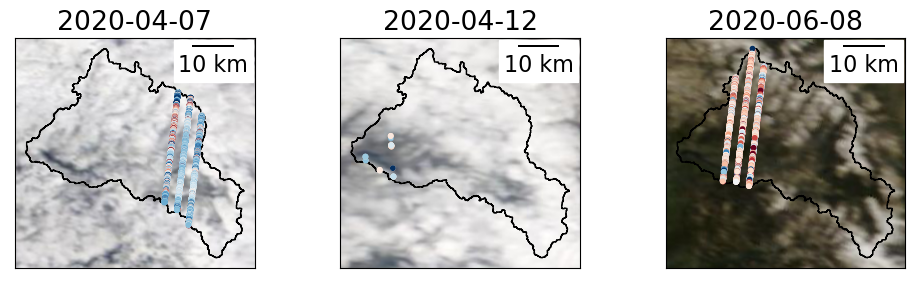

In [11]:
dates_2020 = [datetime.date(2020,4,7), datetime.date(2020,4,12), datetime.date(2020,6,8)]
s=10
basemap = cx.providers.NASAGIBS.ModisTerraTrueColorCR
fig, axa = plt.subplots(1,3, figsize=(10,3))

for ax, date in zip(axa, dates_2020):
    outline_gdf.plot(ax=ax, facecolor='none')
    atl06sr_gdf[atl06sr_gdf['acqdate'] == date].plot(ax=ax, column='diff_plus', cmap = 'RdBu', legend = False, s=s, vmin = -3, vmax = 4)
    #east5.plot(ax=ax, facecolor='none')
    ax.add_artist(ScaleBar(1))
    basemap.update({'time':date})
    cx.add_basemap(ax, attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=9)
    ax.set_title(date)
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    
plt.tight_layout()

In [13]:
aso_date_list = []
for fn in aso_fn_winters:
    date_string = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[-2]
    date = datetime.datetime.strptime(date_string, "%Y%m%d").date()
    aso_date_list.append(date)

In [14]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [15]:
print('aso length:', len(aso_date_list))
print('atl06sr length:', len(atl06_dates))

aso length: 8
atl06sr length: 8


In [38]:
atl06_dates

[datetime.date(2019, 3, 12),
 datetime.date(2019, 4, 10),
 datetime.date(2019, 5, 14),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 6, 8),
 datetime.date(2021, 2, 8),
 datetime.date(2022, 2, 6),
 datetime.date(2022, 4, 3)]

In [53]:
(comp_table[comp_table['acqdate']==atl06_dates[0]]['median'][0] - comp_table[comp_table['acqdate']==aso_date_list[0]]['basin_median'][0]) / comp_table[comp_table['acqdate']==aso_date_list[0]]['basin_median'][0] * 100

-0.4770737068388682

In [46]:
comp_table[comp_table['acqdate']==aso_date_list[0]]['basin_median'][0]

2.838949680328369

In [49]:
comp_table.loc[comp_table['acqdate']==atl06_dates[0], 'median'][0]

2.8254057978531364

In [14]:
# written by Hannah Besso, Oct 14, 2022

def build_basin_df(raster_list = None, region = None):
    stats_df = pd.DataFrame()
    for file in raster_list:
        rasterstats = zonal_stats(region, file, nodata=(-9999.0), stats="mean min max median percentile_25 percentile_75 count")
        rasterstats[0]['iqr'] = rasterstats[0]['percentile_75'] - rasterstats[0]['percentile_25']
        date = os.path.splitext(os.path.split(file)[-1])[0].split('_')[-2]
        date2 = pd.to_datetime(date)
        stats_df = pd.concat([stats_df, pd.DataFrame(rasterstats[0], index=[date2])])
    stats_df['acqdate'] = stats_df.index.date
    return stats_df

In [15]:
def make_pairs_table(df):
    comp_table = pd.DataFrame()
    comp_table.index = pd.DatetimeIndex(data=sorted(atl06_dates + aso_date_list))
    comp_table['acqdate'] = comp_table.index.date
    comp_table['ATL06SR'] = ''
    comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ATL06SR'] = True
    comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ATL06SR'] = False
    comp_table['ASO'] = ''
    comp_table.loc[comp_table['acqdate'].isin(atl06_dates),'ASO'] = False
    comp_table.loc[comp_table['acqdate'].isin(aso_date_list),'ASO'] = True

    comp_table['pair'] = ''
    for i in range(len(comp_table)):
        comp_table['pair'][i:i+1] = int(i/2)

    comp_table['median'] = ''
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['ASO_snowon_date']==date,'ASO_snowon'])

    comp_table['median_diff'] = ''
    for i in comp_table['pair'].unique():
        comp_table.loc[comp_table['pair']==i, 'median_diff'] = np.diff(comp_table[comp_table['pair']==i]['median'])

        
    comp_table['median_track_percent'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'median_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'median_diff'] / comp_table.loc[comp_table['acqdate']==date, 'median'] * 100
    
    comp_table['iqr'] = ''
    for date in atl06_dates:
        comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus'])
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'iqr'] = iqr(df.loc[df['ASO_snowon_date']==date,'ASO_snowon'])

    comp_table['iqr_diff'] = ''
    for i in comp_table['pair'].unique():
        comp_table.loc[comp_table['pair']==i, 'iqr_diff'] = np.diff(comp_table[comp_table['pair']==i]['iqr'])

    comp_table['iqr_track_percent'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'iqr_track_percent'] = comp_table.loc[comp_table['acqdate']==date, 'iqr_diff'] / comp_table.loc[comp_table['acqdate']==date, 'iqr'] * 100    
        
    comp_table['date_offset'] = ''
    for i in range(len(comp_table)):
        if i%2 != 0:
            comp_table.loc[comp_table['pair']==int(i/2), 'date_offset'] = np.subtract(comp_table.index[i],comp_table.index[i-1]).days

    comp_table['tum_depth'] = ''
    # median depth on that day at the tuolumne meadows cdec pillow
    for date in comp_table.index:
        comp_table.loc[comp_table.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']

    comp_table['dan_depth'] = ''
    # median depth on that day at the tuolumne meadows cdec pillow
    for date in comp_table.index:
        comp_table.loc[comp_table.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']

    comp_table['delta_tum'] = ''
    for i in comp_table['pair'].unique():
        comp_table.loc[comp_table['pair']==i, 'delta_tum'] = np.diff(comp_table[comp_table['pair']==i]['tum_depth'])

    comp_table['delta_dan'] = ''
    for i in comp_table['pair'].unique():
        comp_table.loc[comp_table['pair']==i, 'delta_dan'] = np.diff(comp_table[comp_table['pair']==i]['dan_depth'])

    basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)

    comp_table['basin_median'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'basin_median'] = basin_df.loc[basin_df['acqdate']==date,'median']

    comp_table['median_basin_diff'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_diff'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'basin_median'][0])
        
    comp_table['median_basin_percent'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_percent'] = (comp_table.loc[comp_table['acqdate']==date_aso, 'median_basin_diff'][0]) / comp_table.loc[comp_table['acqdate']==date_aso, 'basin_median'][0] * 100

    comp_table['basin_iqr'] = np.nan
    for date in aso_date_list:
        comp_table.loc[comp_table['acqdate']==date, 'basin_iqr'] = basin_df.loc[basin_df['acqdate']==date,'iqr']

    comp_table['iqr_basin_diff'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
            comp_table.loc[comp_table['acqdate']==date_aso, 'iqr_basin_diff'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'iqr'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'basin_iqr'][0])
        
    comp_table['iqr_basin_percent'] = np.nan
    for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
            comp_table.loc[comp_table['acqdate']==date_aso, 'iqr_basin_percent'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'iqr'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'basin_iqr'][0]) / comp_table.loc[comp_table['acqdate']==date_aso, 'basin_iqr'][0] * 100

    return comp_table

In [16]:
comp_table = make_pairs_table(atl06sr_gdf)

In [21]:
atl06sr_gdf.head(2)

,distance,h_sigma,rgt,delta_time,pflags,dh_fit_dy,segment_id,w_surface_window_final,dh_fit_dx,h_mean,spot,gt,cycle,rms_misfit,n_fit_photons,geometry,doy,decyear,dowy,snow_presence,site,acqdate,lidar_z,difference,lidar_z_20m,difference_20m,slope_3m,slope_20m,slope_100m,diff_plus,diff_plus_20m,ASO_snowon,ASO_snowon_date,ASO_snowon_20m
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,4.215353e+06,0.033182,265,2.488094e+07,0,0.0,210188,3.0,-0.018228,2501.377184,4,30,1,0.091912,15,POINT (269304.074 4196719.705),288,2018.788969,15,0,tuolumne,2018-10-15,2501.669922,-0.292738,2501.780029,-0.402845,1.725123,1.438880,NaN,-0.17767,-0.269368,NaN,NaN,NaN
2018-10-15 23:22:20.021811344,4.215373e+06,0.028329,265,2.488094e+07,0,0.0,210189,3.0,-0.010939,2501.116873,4,30,1,0.109110,18,POINT (269302.684 4196739.709),288,2018.788969,15,0,tuolumne,2018-10-15,2501.169922,-0.053049,2501.500000,-0.383127,4.888882,2.426852,NaN,0.06202,-0.249650,NaN,NaN,NaN


In [66]:
comp_table['median_slope20d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['ASO_snowon_date']==date) & (atl06sr_gdf['slope_20m']>20),'ASO_snowon'])

In [67]:
comp_table['median_diff_slope20d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope20d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope20d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope20d'][0])

In [68]:
np.nanmedian(comp_table['median_diff_slope20d'].abs())

0.37856803083661816

In [69]:
comp_table['median_slope10d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['ASO_snowon_date']==date) & (atl06sr_gdf['slope_20m']<10),'ASO_snowon'])

In [70]:
comp_table['median_diff_slop10d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope10d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope10d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope10d'][0])

In [71]:
np.nanmedian(comp_table['median_diff_slope10d'].abs())

0.1672896932503818

In [73]:
comp_table['median_slope5d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<5),'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['ASO_snowon_date']==date) & (atl06sr_gdf['slope_20m']<5),'ASO_snowon'])

In [74]:
comp_table['median_diff_slope5d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope5d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope5d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope5d'][0])

In [75]:
np.nanmedian(comp_table['median_diff_slope5d'].abs())

0.13878070521525387

In [80]:
comp_table['median_slope30t40d'] = np.nan
for date in atl06_dates:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<40) & (atl06sr_gdf['slope_20m']>30),'diff_plus'])
for date in aso_date_list:
    comp_table.loc[comp_table['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['ASO_snowon_date']==date) & (atl06sr_gdf['slope_20m']<40) & (atl06sr_gdf['slope_20m']>30),'ASO_snowon'])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [81]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent,median_slope20d,median_diff_slope20d,median_slope10d,median_diff_slop10d,median_diff_slope10d,median_slope5d,median_diff_slope5d,median_slope30t40d,median_diff_slope30t40d,median_diff_slope30t4030t40d
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,2.346042,NaN,3.139580,NaN,NaN,3.206431,NaN,2.219496,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,-0.013544,-0.477074,1.714828,1.194208,69.640142,2.509993,-0.163951,3.351546,NaN,-0.211965,3.504744,-0.298313,2.405379,NaN,-0.185883
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.802213,NaN,2.378372,NaN,NaN,2.360785,NaN,2.891115,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,-0.092099,-3.619612,1.885017,-0.636813,-33.782884,3.069210,-0.266997,2.427243,NaN,-0.048871,2.424191,-0.063406,3.212399,NaN,-0.321284
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-0.123183,-7.164508,1.988614,-0.210380,-10.579248,2.313203,-0.539878,1.854707,NaN,-0.498472,1.720186,-0.580980,2.371675,NaN,-0.986065
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,NaN,1.778233,0.630284,NaN,11,0.4064,1.143,-0.635,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN,1.773325,NaN,1.356235,NaN,NaN,1.139205,NaN,1.385609,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,NaN,1.422136,-0.578227,NaN,6,0.7112,NaN,-0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.087805,NaN,1.254452,NaN,NaN,1.132976,NaN,0.829265,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,-27.140498,0.843909,-0.578227,-68.517762,6,0.4572,1.524,-0.254,NaN,0.983526,0.312670,31.790754,1.181436,0.240700,20.373464,0.998626,0.089180,0.964934,NaN,0.289518,0.884368,0.248608,0.925188,NaN,-0.095924
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,inf,0.298129,1.01513,340.499902,17,0.0508,0.0,0.0254,0.0,0.010931,0.030725,281.066764,0.337922,0.975338,288.628022,0.000000,0.111278,0.000000,NaN,-0.053450,0.000000,-0.092874,0.000000,NaN,-0.070910
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,NaN,1.313259,1.01513,NaN,17,0.0762,0.0,0.0254,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.111278,NaN,-0.053450,NaN,NaN,-0.092874,NaN,-0.070910,NaN,NaN


In [82]:
comp_table['median_diff_slope30t40d'] = np.nan
for date_atl06, date_aso in zip(atl06_dates,aso_date_list):
        comp_table.loc[comp_table['acqdate']==date_aso, 'median_diff_slope30t40d'] = (comp_table.loc[comp_table['acqdate']==date_atl06, 'median_slope30t40d'][0] - comp_table.loc[comp_table['acqdate']==date_aso, 'median_slope30t40d'][0])

In [83]:
np.nanmedian(comp_table['median_diff_slope30t40d'].abs())

0.32128414635849367

In [28]:
pairs_tumradius = make_pairs_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [29]:
pairs_danradius = make_pairs_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [145]:
#comp_table.to_csv('../../figures/comp_table_pairs.csv')

In [110]:
basin_df = build_basin_df(raster_list=aso_fn_winters, region=outline_gdf)
basin_df

,min,max,mean,count,median,percentile_25,percentile_75,iqr,acqdate
2019-03-24,-1.039112,22.367649,2.744573,2915368,2.838950,1.887053,3.601881,1.714828,2019-03-24
2019-04-17,-0.879300,22.962400,2.443612,2915748,2.544456,1.465045,3.350062,1.885017,2019-04-17
2019-05-03,-1.206003,42.400269,1.708364,2915383,1.719352,0.533913,2.522527,1.988614,2019-05-03
2020-04-13,-0.292035,21.189863,0.983854,2646253,0.983526,0.289719,1.471155,1.181436,2020-04-13
2020-05-22,-0.218361,20.824833,0.265674,2792407,0.010931,0.000000,0.337922,0.337922,2020-05-22
2021-02-25,-0.366888,7.820531,0.966758,2906850,1.049031,0.621652,1.327524,0.705872,2021-02-25
2022-02-04,-0.232013,11.518790,1.000802,1235354,1.036890,0.647384,1.318633,0.671249,2022-02-04
2022-04-05,-0.200172,11.080725,0.609790,1157340,0.508277,0.115128,0.909294,0.794165,2022-04-05


In [105]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,-0.013544,-0.477074,1.714828,1.194208,69.640142
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,-0.092099,-3.619612,1.885017,-0.636813,-33.782884
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-0.123183,-7.164508,1.988614,-0.210380,-10.579248
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,NaN,1.778233,0.630284,NaN,11,0.4064,1.143,-0.635,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,NaN,1.422136,-0.578227,NaN,6,0.7112,NaN,-0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,-27.140498,0.843909,-0.578227,-68.517762,6,0.4572,1.524,-0.254,NaN,0.983526,0.312670,31.790754,1.181436,0.240700,20.373464
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,inf,0.298129,1.01513,340.499902,17,0.0508,0.0,0.0254,0.0,0.010931,0.030725,281.066764,0.337922,0.975338,288.628022
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,NaN,1.313259,1.01513,NaN,17,0.0762,0.0,0.0254,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
median_dif = comp_table['median_diff']

In [139]:
np.sort(median_dif.abs())

array([4.899748319076025e-06, 4.899748319076025e-06, 0.04165602668763313,
       0.04165602668763313, 0.10647727818263775, 0.10647727818263775,
       0.1556563759902474, 0.1556563759902474, 0.22236200336578804,
       0.22236200336578804, 0.23193502764502227, 0.23193502764502227,
       0.27669725018768077, 0.27669725018768077, 0.44176575335950474,
       0.44176575335950474], dtype=object)

In [138]:
len(median_dif)

16

In [141]:
basin_dif = comp_table['median_basin_diff']

In [143]:
np.sort(basin_dif.abs())

array([0.01354388, 0.0307246 , 0.08152943, 0.09209945, 0.1231831 ,
       0.1515677 , 0.20371099, 0.31267044,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])

In [98]:
np.nanmedian(comp_table['median_basin_diff'].abs())

0.10764127256504707

In [99]:
np.nanmedian(comp_table['median_basin_percent'].abs())

15.328938327485382

In [106]:
np.nanmedian(comp_table['iqr_basin_diff'].abs())

0.5554237444039245

In [107]:
np.nanmedian(comp_table['iqr_basin_percent'].abs())

50.469380230148346

In [121]:
np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)]['median_diff'].abs())

0.18900918967801772

In [122]:
np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)]['date_offset'].abs())

9.0

In [ ]:
metrics = ['date_offset', 'median_diff', 'median_track_percent', 'iqr_diff', 'iqr_track_percent', \
          'delta_tum', 'delta_dan', 'basin_median', 'median_basin_diff']

In [131]:
comp_table.columns[4:6]

Index(['median', 'median_diff'], dtype='object')

In [132]:
for column in comp_table.columns[4:5]:
    print(column, "atl06 median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(atl06_dates)][column].abs()))
for column in comp_table.columns[4:5]:
    print(column, "aso median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(aso_date_list)][column].abs()))
for column in comp_table.columns[5:6]:
    print(column, "median:", np.nanmedian(comp_table[column].abs()))
for column in comp_table.columns[6:]:
    print(column, "median:", np.nanmedian(comp_table[comp_table['acqdate'].isin(aso_date_list)][column].abs()))

median atl06 median: 1.0907595597576574
median aso median: 1.0924696922302246
median_diff median: 0.18900918967801772
median_track_percent median: 20.79296636968199
iqr median: 0.6839798092842102
iqr_diff median: 0.6042556821217886
iqr_track_percent median: 71.7444662298708
date_offset median: 9.0
tum_depth median: 1.0795000000000001
dan_depth median: 1.4986
delta_tum median: 0.11429999999999993
delta_dan median: 0.10160000000000008
basin_median median: 1.042960524559021
median_basin_diff median: 0.10764127256504707
median_basin_percent median: 15.328938327485382
basin_iqr median: 0.9878007937222719
iqr_basin_diff median: 0.5554237444039245
iqr_basin_percent median: 50.469380230148346


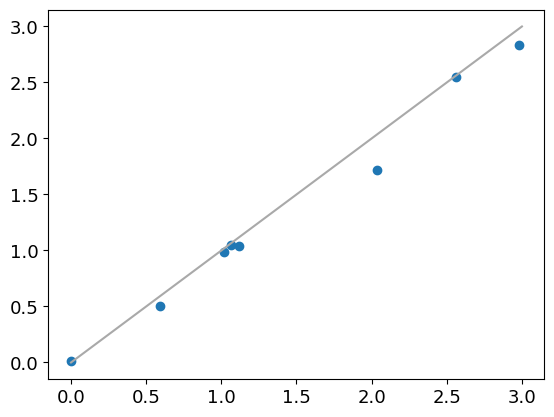

In [61]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table['basin_median'], comp_table['median'])
ax.plot(x, y, 'darkgrey', label='1:1 line')
ax.set_xlabel('Basin Median (ASO)')

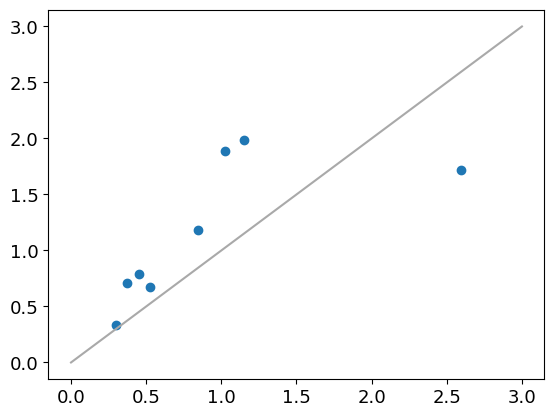

In [62]:
x = np.linspace(0,3,100)
y = x

fig, ax = plt.subplots()
ax.scatter(comp_table['iqr'], comp_table['basin_iqr'])
ax.plot(x, y, 'darkgrey', label='1:1 line')

Text(0, 0.5, 'delta snow depth during \nthe date offset at tum')

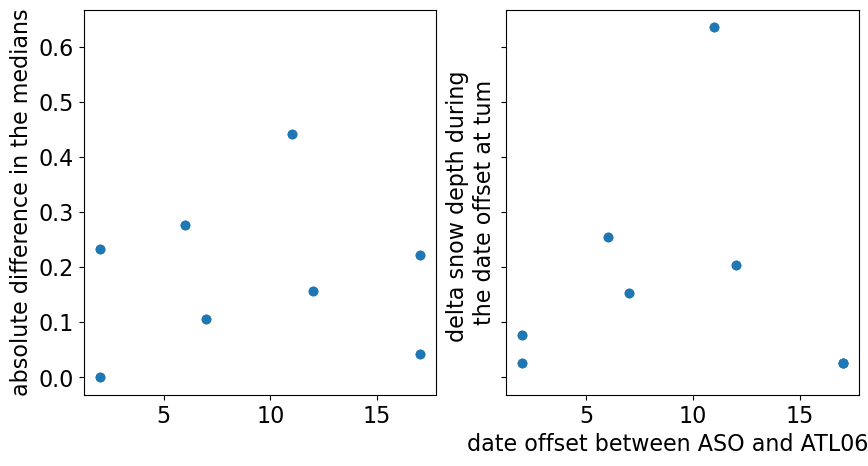

In [98]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].scatter(comp_table['date_offset'], comp_table['median_diff'].abs())
#ax[0].set_xlabel('date offset between ASO and ATL06SR')
ax[0].set_ylabel('absolute difference in the medians')

ax[1].scatter(comp_table['date_offset'], comp_table['delta_tum'].abs())
ax[1].set_xlabel('date offset between ASO and ATL06SR')
ax[1].set_ylabel('delta snow depth during \nthe date offset at tum')

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

In [62]:
# Old Plotting Function

# def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations):
    
#     basemap = cx.providers.Stamen.TerrainBackground
    
#     fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios':[1,2], 'width_ratios':[1,1]})
    
#     # Plot changes in snow depth
#     x = np.linspace(-7,0.3,100)
#     y = x

#     c=ax[0,0].scatter(df['delta_tum'], df['median_diff'], c=df['pair'], cmap='Blues_r')
#     ax[0,0].plot(x, y, 'darkgrey', label='1:1 line')
#     ax[0,0].axvline(x=0, ymin=(-0.7), ymax=1, color='grey')
#     ax[0,0].axhline(y=0, xmin=(-0.7), xmax=1, color='grey')
#     plt.colorbar(c, label='Pair', ax=ax[0,0])
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     ax[0,0].set_ylim(-0.7, 0.3)
#     ax[0,0].set_xlim(-0.7, 0.3)
#     ax[0,0].set_xlabel('Change in TUM Depth (m)')
#     ax[0,0].set_ylabel('median difference (ATL06SR-ASO)')
#     ax[0,0].set_facecolor('lightgrey')

In [141]:
# Old Plotting Function

# def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations):
    
#     basemap = cx.providers.Stamen.TerrainBackground
#     # code from https://towardsdatascience.com/customizing-multiple-subplots-in-matplotlib-a3e1c2e099bc
#     fig = plt.figure(figsize=(10, 8))

#     plt.subplots_adjust(wspace= 0.5, hspace= 0.25)

#     sub1 = fig.add_subplot(2,2,1) # two rows, two columns, fist cell
#     sub1.scatter(df['delta_tum'], df['median_diff'], c=df['pair'].map(colordict))
#     sub1.plot(x, y, 'darkgrey', label='1:1 line')
#     sub1.axvline(x=0, ymin=(-0.7), ymax=1, color='lightgrey')
#     sub1.axhline(y=0, xmin=(-0.7), xmax=1, color='lightgrey')
#     #plt.colorbar(c, label='Pair', ax=sub1)
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     sub1.set_ylim(-0.7, 0.3)
#     sub1.set_xlim(-0.7, 0.3)
#     sub1.set_xlabel('Tuolumne Meadows \nDepth Change (m)')
#     sub1.set_ylabel('Median Difference \nBetween Pairs (m)')
#     #sub1.set_facecolor('lightgrey')
    
#     # Create second axes, the top-left plot with orange plot
#     sub2 = fig.add_subplot(2,2,2) # two rows, two columns, second cell
#     sub2.scatter(df['delta_dan'], df['median_diff'], c=df['pair'].map(colordict))
#     sub2.plot(x, y, 'darkgrey', label='1:1 line')
#     sub2.axvline(x=0, ymin=(-0.7), ymax=1, color='lightgrey')
#     sub2.axhline(y=0, xmin=(-0.7), xmax=1, color='lightgrey')
#     #plt.colorbar(c, label='Number of Days \nBetween Measurements')
#     #plt.ylim(-100, 100)
#     #plt.hlines(y=0, xmin=0, xmax=17.5, color='k', linestyle='--')
#     sub2.set_ylim(-0.7, 0.3)
#     sub2.set_xlim(-0.7, 0.3)
#     sub2.set_xlabel('Dana Meadow \nDepth Change (m)')
#     sub2.set_ylabel('Median Difference \nBetween Pairs (m)')
#     #sub2.set_facecolor('lightgrey')
    
#     # Create third axes, a combination of third and fourth cell
#     sub3 = fig.add_subplot(2,2,(3,4)) # two rows, two colums, combined third and fourth cell
#     gdf[gdf['ASO_snowon_date'].isin(aso_date_list)].plot(column='acqdate', cmap=pair_cmap, ax=sub3, markersize=3, \
#                 legend=True, legend_kwds={'bbox_to_anchor':(0.93, 1.02)})
#     roi.plot(ax=sub3, facecolor='none', edgecolor='k')
#     cx.add_basemap(ax=sub3, attribution=False, crs='epsg:32611', source=basemap, zoom=11)
#     roi_reverse.plot(ax=sub3, facecolor='white')
#     wx_stations[0:2].plot(ax=sub3, color='k', marker='*', markersize=100, label='CDEC Sites', legend=True)
#     wx_stations[2:].plot(ax=sub3, facecolor='none',edgecolor='k')
#     # legend = sub3.legend(snow, 'CDEC Sites', loc='upper left')
#     # sub3.add_artist(legend)
#     sub3.set_xlim(250000, 310000)
#     sub3.set_ylim(4178000, 4232000)
#     sub3.set_axis_off()
#     plt.savefig('../../figures/polished/pairs_cdec_locations.jpeg', dpi = 500, bbox_inches = 'tight')

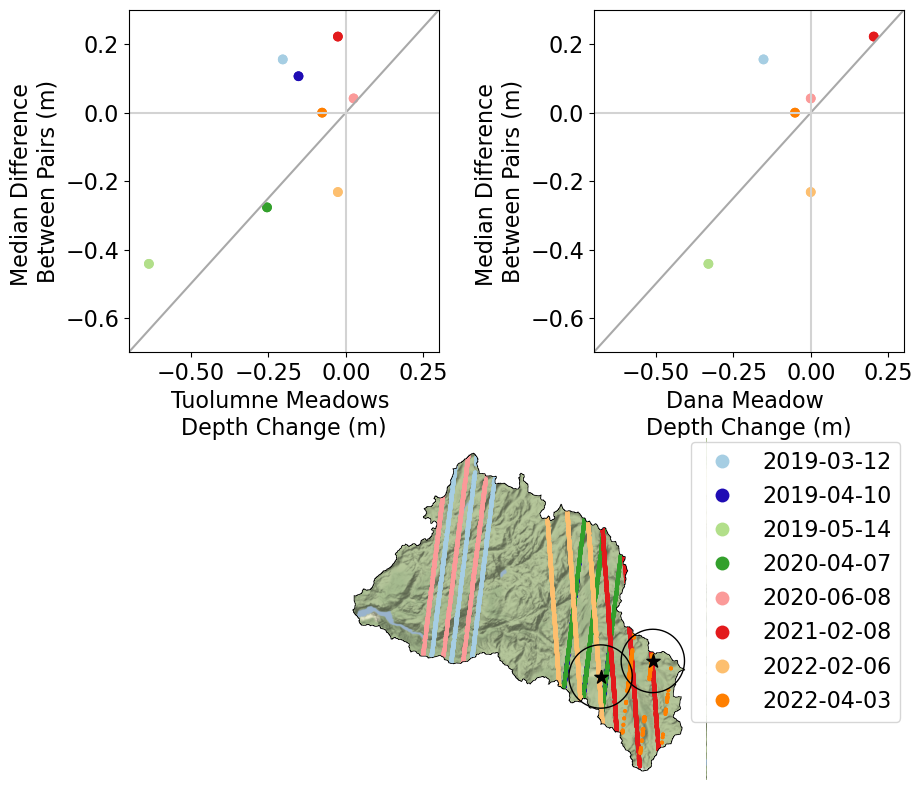

In [142]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [18]:
import matplotlib
pair_colors = [(166/255,206/255,227/255), (31/255,12/255,180/255), (178/255,223/255,138/255), (51/255,160/255,44/255), \
               (251/255,154/255,153/255), (227/255,26/255,28/255), (253/255,191/255,111/255), (255/255,127/255,0/255)]
pair_cmap = matplotlib.colors.ListedColormap(pair_colors)
pair_cmap_2019 = matplotlib.colors.ListedColormap(pair_colors[0:3])
pair_cmap_not2019 = matplotlib.colors.ListedColormap(pair_colors[3:])


In [19]:
categories = np.unique(comp_table['pair'])
#colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, pair_colors))  

In [21]:
comp_table.head()

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_percent,basin_iqr,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,5.482886,1.714828,-18.243507
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,4.184677,1.885017,-11.904404
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-25.693737,1.988614,31.694648


In [70]:
aso_date_list

[datetime.date(2019, 3, 24),
 datetime.date(2019, 4, 17),
 datetime.date(2019, 5, 3),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 5, 22),
 datetime.date(2021, 2, 25),
 datetime.date(2022, 2, 4),
 datetime.date(2022, 4, 5)]

In [20]:
from matplotlib.lines import Line2D

custom = [Line2D([], [], marker='*', markersize=12, markerfacecolor='white', markeredgecolor='black', linestyle='None')]
for color in pair_colors:
    custom.append(Line2D([], [], marker='.', markersize=15, color=color, linestyle='None'))
    
atl06_dates_string = []
for i in atl06_dates:
    atl06_dates_string.append(i.strftime('%Y-%m-%d'))
custom_labels = atl06_dates_string.copy()
custom_labels.insert(0, 'CDEC sites')

aso_date_list_2019 = aso_date_list[0:3]
aso_date_list_not2019 = aso_date_list[3:]

In [21]:
def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations, columnsA=['delta_tum','median_diff'], columnsB=['delta_dan', 'median_diff'], clim=(0,3)):
    
    basemap = cx.providers.Stamen.TerrainBackground
    # code from https://towardsdatascience.com/customizing-multiple-subplots-in-matplotlib-a3e1c2e099bc
    mosaic= """
        AB
        CD
        """
    
    # Make 1:1 line
    x = np.linspace(clim[0]-1,clim[1]+1,100)
    y = x
    
    fig = plt.figure(tight_layout=True, figsize=(9,7))
    ax_dict = fig.subplot_mosaic(mosaic) #, gridspec_kw={'wspace':0, 'hspace':0}
    #hpad and wpad to zero
    #plt.subplots_adjust(wspace= 0.5, hspace= 0.25)
    #matplotlib.rc('axes',edgecolor='black')
    #with plt.rc_context({'axes.edgecolor':'white'}):
    ax_dict['A'].plot(x, y, 'darkgrey', label='1:1 line')
    ax_dict['A'].scatter(df[columnsA[0]], df[columnsA[1]], c=df['pair'].map(colordict))
    # ax_dict['A'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['A'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey') 
    ax_dict['A'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlabel(columnsA[0])
    ax_dict['A'].set_ylabel(columnsA[1])
    ax_dict['A'].annotate(text='A)', xy=(0.05,0.9), xycoords='axes fraction')

    # Create second axes, the top-left plot with orange plot
    ax_dict['B'].plot(x, y, 'darkgrey', label='1:1 line')
    ax_dict['B'].scatter(df[columnsB[0]], df[columnsB[1]], c=df['pair'].map(colordict))
    # ax_dict['B'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['B'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey')
    ax_dict['B'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlabel(columnsB[0])
    ax_dict['B'].set_ylabel(columnsB[1])
    ax_dict['B'].annotate(text='B)', xy=(0.05,0.9), xycoords='axes fraction')
    
    # for child in ax.get_children():
    # if isinstance(child, matplotlib.spines.Spine):
    #     child.set_color('#dddddd')

    for ax in [ax_dict['C'], ax_dict['D']]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    # Create third axes, a combination of third and fourth cell
    #with plt.rc_context({'axes.edgecolor':'white'}):
    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_2019)].plot(column='acqdate', cmap=pair_cmap_2019, ax=ax_dict['C'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['C'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['C'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['C'], facecolor='white')
    wx_stations[0:2].plot(ax=ax_dict['C'], facecolor='white', edgecolor='black', marker='*', markersize=100, label='CDEC Sites')
    # customize my legend
    ax_dict['C'].legend(custom, custom_labels, loc='lower left', fontsize=12, borderaxespad=0, bbox_to_anchor=(0.97,0.05), bbox_transform=ax_dict['C'].transAxes) # title='Pair Dates', 
    ax_dict['C'].set_xlim(250000, 310000)
    ax_dict['C'].set_ylim(4178000, 4232000)
    ax_dict['C'].axes.get_xaxis().set_ticks([])
    ax_dict['C'].axes.get_yaxis().set_ticks([])
    ax_dict['C'].annotate(text='C)', xy=(0.05,0.9), xycoords='axes fraction')
    ax_dict['C'].set_title('2019 ATL06SR Tracks')
    #ax_dict['C'].set_axis_off()

    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_not2019)].plot(column='acqdate', cmap=pair_cmap_not2019, ax=ax_dict['D'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['D'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['D'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['D'], facecolor='white')
    wx_stations[0:2].plot(ax=ax_dict['D'], facecolor='white', edgecolor='black', marker='*', markersize=100, label='CDEC Sites', legend=True)
    ax_dict['D'].set_xlim(250000, 310000)
    ax_dict['D'].set_ylim(4178000, 4232000)
    ax_dict['D'].axes.get_xaxis().set_ticks([])
    ax_dict['D'].axes.get_yaxis().set_ticks([])
    ax_dict['D'].annotate(text='D)', xy=(0.05,0.9), xycoords='axes fraction')
    #ax_dict['D'].set_axis_off()
    ax_dict['D'].set_title('2020-2022 ATL06SR Tracks')
    # fig.get_layout_engine().set(w_pad=-1, h_pad=-1, hspace=-1,
    #                         wspace=-1)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('../../figures/polished/pairs_cdec_locations.jpeg', dpi = 500, bbox_inches = 'tight')

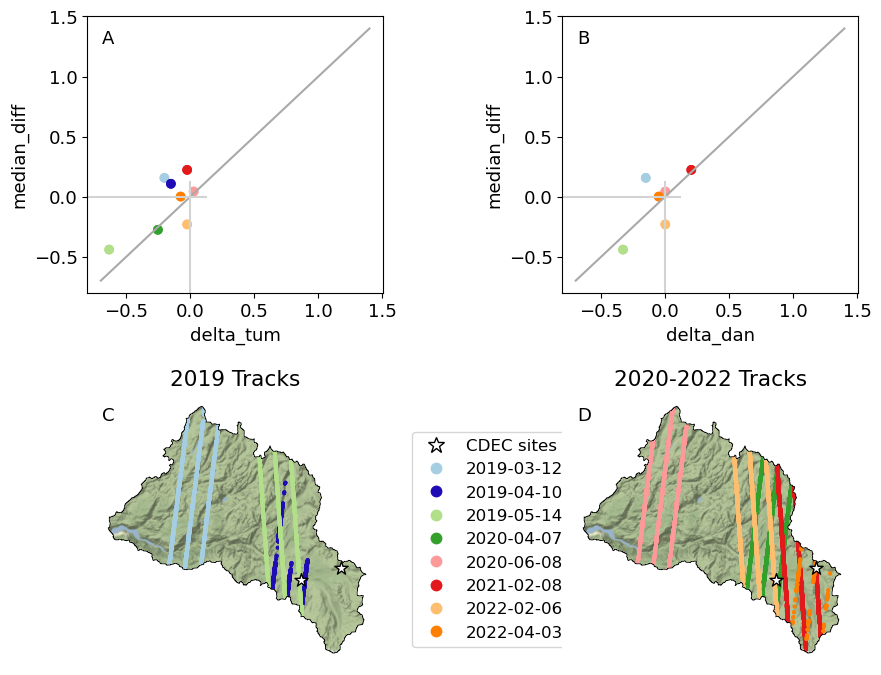

In [83]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom, clim=(-0.7, 0.4))

In [109]:
comp_table

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_diff,median_basin_percent,basin_iqr,iqr_basin_diff,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.838950,-0.013544,-0.477074,1.714828,1.194208,69.640142
2019-04-10,2019-04-10,True,False,1,2.452357,0.106477,NaN,1.248204,-0.2244,NaN,7,2.032,NaN,-0.1524,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-17,2019-04-17,False,True,1,2.558834,0.106477,4.161163,1.023804,-0.2244,-21.918265,7,1.8796,2.2352,-0.1524,NaN,2.544456,-0.092099,-3.619612,1.885017,-0.636813,-33.782884
2019-05-03,2019-05-03,False,True,2,2.037935,-0.441766,-21.677132,1.147949,0.630284,54.905226,11,1.0414,1.4732,-0.635,-0.3302,1.719352,-0.123183,-7.164508,1.988614,-0.210380,-10.579248
2019-05-14,2019-05-14,True,False,2,1.596169,-0.441766,NaN,1.778233,0.630284,NaN,11,0.4064,1.143,-0.635,-0.3302,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-07,2020-04-07,True,False,3,1.296197,-0.276697,NaN,1.422136,-0.578227,NaN,6,0.7112,NaN,-0.254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,2020-04-13,False,True,3,1.0195,-0.276697,-27.140498,0.843909,-0.578227,-68.517762,6,0.4572,1.524,-0.254,NaN,0.983526,0.312670,31.790754,1.181436,0.240700,20.373464
2020-05-22,2020-05-22,False,True,4,0.0,0.041656,inf,0.298129,1.01513,340.499902,17,0.0508,0.0,0.0254,0.0,0.010931,0.030725,281.066764,0.337922,0.975338,288.628022
2020-06-08,2020-06-08,True,False,4,0.041656,0.041656,NaN,1.313259,1.01513,NaN,17,0.0762,0.0,0.0254,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
plt.rcParams['font.size'] = '20'

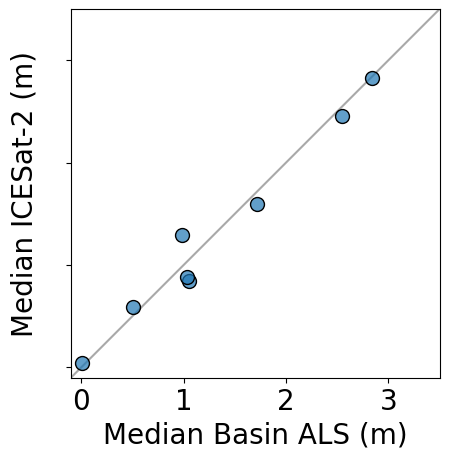

In [43]:
from matplotlib.ticker import MaxNLocator

clim=(-0.1,3.5)
x = np.linspace(clim[0]-1,clim[1]+1,100)
y = x
    
fig, ax = plt.subplots(figsize=(5,5)) 
ax.plot(x, y, 'darkgrey', label='1:1 line', zorder=1)
ax.scatter(comp_table[comp_table['acqdate'].isin(aso_date_list)]['basin_median'], comp_table[comp_table['acqdate'].isin(atl06_dates)]['median'], \
                     color=(31/255,119/255, 180/255, 0.7), s=100, edgecolor='k', zorder=2)
# ax_dict['A'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
# ax_dict['A'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey') 
#ax.set_ylim(clim[0]-0.1, clim[1]+0.1)
#ax.set_xlim(clim[0]-0.1, clim[1]+0.1)
ax.set_xlabel('Median Basin ALS (m)')
ax.set_ylabel('Median ICESat-2 (m)')
#ax.annotate(text='A)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
ax.set_ylim(*clim)
ax.set_xlim(*clim)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.yticks(color='w')
#ax.axhline(0, color='k', lw=0.5)
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../../figures/polished/pairs_cdec_proposal.jpeg', dpi = 500)

In [41]:
def plot_pair_locations(gdf, df, roi, roi_reverse, wx_stations, clim=(0,3)):
    
    basemap = cx.providers.Stamen.TerrainBackground
    # code from https://towardsdatascience.com/customizing-multiple-subplots-in-matplotlib-a3e1c2e099bc
    mosaic= """
        AB
        CD
        """
    
    # Make 1:1 line
    x = np.linspace(clim[0]-1,clim[1]+1,100)
    y = x
    
    fig = plt.figure(figsize=(9,7.5)) #tight_layout=True, 
    ax_dict = fig.subplot_mosaic(mosaic) #, gridspec_kw={'wspace':0, 'hspace':0}
    #hpad and wpad to zero
    #plt.subplots_adjust(wspace= 0.5, hspace= 0.25)
    #matplotlib.rc('axes',edgecolor='black')
    #with plt.rc_context({'axes.edgecolor':'white'}):
    ax_dict['A'].plot(x, y, 'darkgrey', label='1:1 line', zorder=1)
    ax_dict['A'].scatter(df[df['acqdate'].isin(aso_date_list)]['basin_median'], df[df['acqdate'].isin(atl06_dates)]['median'], \
                         c=df[df['acqdate'].isin(aso_date_list)]['pair'].map(colordict), s=50, edgecolor='k', zorder=2)
    # ax_dict['A'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['A'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey') 
    ax_dict['A'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['A'].set_xlabel('Median Basin ASO Snow Depth (m)')
    ax_dict['A'].set_ylabel('Median ATL06-SR Snow Depth (m)')
    ax_dict['A'].annotate(text='A)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
    ax_dict['A'].set_aspect('equal')

    # Create second axes, the top-left plot with orange plot
    ax_dict['B'].plot(x, y, 'darkgrey', label='1:1 line', zorder=1)
    ax_dict['B'].scatter(df[df['acqdate'].isin(aso_date_list)]['median'], df[df['acqdate'].isin(atl06_dates)]['median'], \
                         c=df[df['acqdate'].isin(aso_date_list)]['pair'].map(colordict), s=50, edgecolor='k', zorder=2)
    # ax_dict['B'].axvline(x=0, ymin=clim[0], ymax=clim[1], color='lightgrey')
    # ax_dict['B'].axhline(y=0, xmin=clim[0], xmax=clim[1], color='lightgrey')
    ax_dict['B'].set_ylim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlim(clim[0]-0.1, clim[1]+0.1)
    ax_dict['B'].set_xlabel('Median Sampled ASO Snow Depth (m)')
    ax_dict['B'].set_ylabel('Median ATL06-SR Snow Depth (m)')
    ax_dict['B'].annotate(text='B)', xy=(0.05,0.9), xycoords='axes fraction', fontsize=14)
    ax_dict['B'].set_aspect('equal')
    
    # for child in ax.get_children():
    # if isinstance(child, matplotlib.spines.Spine):
    #     child.set_color('#dddddd')

    for ax in [ax_dict['C'], ax_dict['D']]:
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.spines['right'].set_color('white')
    # Create third axes, a combination of third and fourth cell
    #with plt.rc_context({'axes.edgecolor':'white'}):
    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_2019)].plot(column='acqdate', cmap=pair_cmap_2019, ax=ax_dict['C'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['C'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['C'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['C'], facecolor='white')
    wx_stations[0:2].plot(ax=ax_dict['C'], facecolor='white', edgecolor='black', marker='*', markersize=100, label='CDEC Sites')
    # customize my legend
    ax_dict['C'].legend(custom, custom_labels, loc='lower left', fontsize=12, borderaxespad=0, bbox_to_anchor=(0.97,0.05), bbox_transform=ax_dict['C'].transAxes) # title='Pair Dates', 
    ax_dict['C'].set_xlim(250000, 310000)
    ax_dict['C'].set_ylim(4178000, 4232000)
    ax_dict['C'].axes.get_xaxis().set_ticks([])
    ax_dict['C'].axes.get_yaxis().set_ticks([])
    #ax_dict['C'].annotate(text='C)', xy=(0.05,0.9), xycoords='axes fraction')
    ax_dict['C'].set_title('C) 2019 ATL06-SR Tracks', fontsize=14)
    #ax_dict['C'].set_axis_off()

    gdf[gdf['ASO_snowon_date'].isin(aso_date_list_not2019)].plot(column='acqdate', cmap=pair_cmap_not2019, ax=ax_dict['D'], markersize=3, \
                legend=False)
    roi.plot(ax=ax_dict['D'], facecolor='none', edgecolor='k')
    cx.add_basemap(ax=ax_dict['D'], attribution=False, crs='epsg:32611', source=basemap, zoom=11)
    roi_reverse.plot(ax=ax_dict['D'], facecolor='white')
    wx_stations[0:2].plot(ax=ax_dict['D'], facecolor='white', edgecolor='black', marker='*', markersize=100, label='CDEC Sites', legend=True)
    ax_dict['D'].set_xlim(250000, 310000)
    ax_dict['D'].set_ylim(4178000, 4232000)
    ax_dict['D'].axes.get_xaxis().set_ticks([])
    ax_dict['D'].axes.get_yaxis().set_ticks([])
    #ax_dict['D'].annotate(text='D)', xy=(0.05,0.9), xycoords='axes fraction')
    #ax_dict['D'].set_axis_off()
    ax_dict['D'].set_title('D) 2020-2022 ATL06-SR Tracks', fontsize=14)
    # fig.get_layout_engine().set(w_pad=-1, h_pad=-1, hspace=-1,
    #                         wspace=-1)
    #plt.subplots_adjust(hspace=0, wspace=0)
    plt.tight_layout()
    plt.savefig('../../figures/polished/pairs_cdec_locations_pres.jpeg', dpi = 500) #, bbox_inches = 'tight'

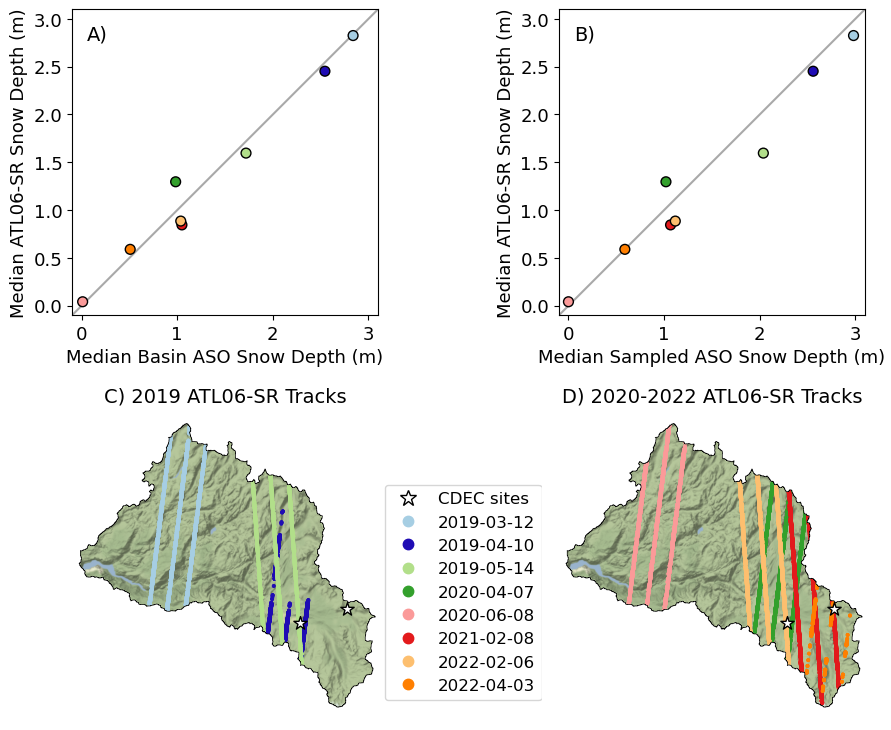

In [42]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [26]:
from sklearn.metrics import r2_score

aso = comp_table[comp_table['acqdate'].isin(aso_date_list)]['basin_median'] 
atl06sr = comp_table[comp_table['acqdate'].isin(atl06_dates)]['median']

R_square = r2_score(aso, atl06sr)
R_square

In [28]:
aso = comp_table[comp_table['acqdate'].isin(aso_date_list)]['median'] 
atl06sr = comp_table[comp_table['acqdate'].isin(atl06_dates)]['median']

R_square = r2_score(aso, atl06sr)
R_square

0.9427217979332602

In [ ]:
plot_pair_locations(atl06sr_gdf, comp_table, outline_gdf, tuol_reverse, cdec_geom)

In [31]:
comp_table.head(2)

,acqdate,ATL06SR,ASO,pair,median,median_diff,median_track_percent,iqr,iqr_diff,iqr_track_percent,date_offset,tum_depth,dan_depth,delta_tum,delta_dan,basin_median,median_basin_percent,basin_iqr,iqr_basin_percent
2019-03-12,2019-03-12,True,False,0,2.825406,0.155656,NaN,2.909036,-0.312845,NaN,12,2.4892,2.7178,-0.2032,-0.1524,NaN,NaN,NaN,NaN
2019-03-24,2019-03-24,False,True,0,2.981062,0.155656,5.221507,2.596191,-0.312845,-12.05014,12,2.286,2.5654,-0.2032,-0.1524,2.83895,5.482886,1.714828,-18.243507


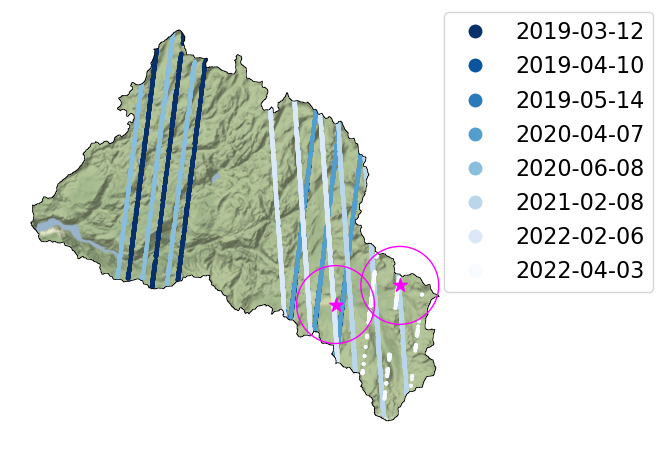

In [58]:
basemap = cx.providers.Stamen.TerrainBackground

fig, ax = plt.subplots()

atl06sr_gdf[atl06sr_gdf['ASO_snowon_date'].isin(aso_date_list)].plot(column='acqdate', cmap='Blues_r', ax=ax, markersize=3, \
                legend=True, legend_kwds={'bbox_to_anchor':(0.94, 1.02)})
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
cx.add_basemap(ax=ax, attribution=False, crs='epsg:32611', source=basemap, zoom=11)
tuol_reverse.plot(ax=ax, facecolor='white')
cdec_geom[0:2].plot(ax=ax, color='magenta', marker='*', markersize=100)
cdec_geom[2:].plot(ax=ax, facecolor='none',edgecolor='magenta')
ax.set_axis_off()
plt.tight_layout()
#plt.savefig('../../figures/date_offset_map.jpeg', dpi=300)

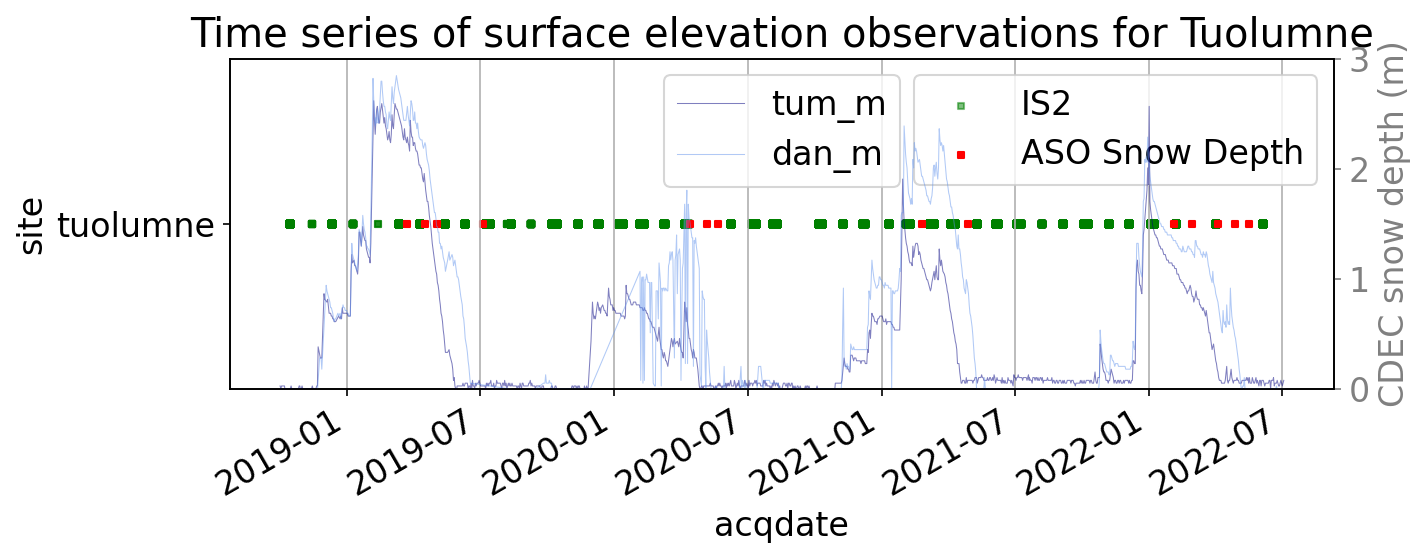

In [211]:
df_list = [aso_gdf, atl06sr_gdf]

f, ax = plt.subplots(figsize=(10,4), dpi=150)
mykw = {'s':10, 'marker':'s', 'kind':'scatter'}

pd.DataFrame(df_list[1].drop(columns='geometry')).plot(ax=ax, alpha=0.5, x='acqdate', y='site', color='g', label='IS2', **mykw)
pd.DataFrame(df_list[0].drop(columns='geometry')).plot(ax=ax, x='acqdate', y='site', color='r', label='ASO Snow Depth', **mykw)

ax1 = ax.twinx()
snwd[snwd['tum_m'] < 2.9]['tum_m'].plot(ax=ax1, alpha=0.5, color='navy', lw=0.5, style='-')
snwd[snwd['dan_m'] < 2.9]['dan_m'].plot(ax=ax1, alpha=0.5, color='cornflowerblue', lw=0.5, style='-')
ax1.set_ylabel('CDEC snow depth (m)', color='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.set_ylim(0,3)
plt.legend(loc='best')

#ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
f.autofmt_xdate()
ax.grid(axis='x', which='major')
ax.set_title('Time series of surface elevation observations for Tuolumne')
plt.tight_layout()
plt.savefig('../../figures/timeseries.jpeg')

## Create this table for all ATL06SR Data

In [17]:
def make_comparison_table(df):
    comp_table_all = pd.DataFrame()
    comp_table_all.index = pd.DatetimeIndex(data=df['acqdate'].unique())
    comp_table_all['acqdate'] = comp_table_all.index.date
    # compute the median depth for each ATL06 date
    comp_table_all['median'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'median'] = np.nanmedian(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the iqr for each ATL06 date
    comp_table_all['iqr'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'iqr'] = iqr(df.loc[df['acqdate']==date,'diff_plus'])
    # compute the sample size for each ATL06 date
    comp_table_all['n'] = ''
    for date in comp_table_all['acqdate']:
        comp_table_all.loc[comp_table_all['acqdate']==date, 'n'] = df.loc[df['acqdate']==date, 'diff_plus'].count()
    # compute the depth on that day at the tuolumne meadows cdec pillow
    comp_table_all['tum_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'tum_depth'] = snwd[snwd.index == date]['tum_m']
    # compute the depth on that day at the dana meadows cdec pillow
    comp_table_all['dan_depth'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'dan_depth'] = snwd[snwd.index == date]['dan_clean']
    # compute the difference between the atl06 median depth and the depth on that day at the dana meadows snow pillow
    comp_table_all['atl06-dan_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'dan_depth']
    # compute the percent difference between the atl06 median depth and dana meadows.
    comp_table_all['atl06-dan_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-dan_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-dan_diff'] / comp_table_all.loc[comp_table_all.index==date,'dan_depth']) * 100
    # compute the difference between the atl06 median depth and the depth on that day at the tuolumne meadows snow pillow    
    comp_table_all['atl06-tum_diff'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] = comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'tum_depth']
    # compute the percent difference between the atl06 median depth and tuolumne meadows.
    comp_table_all['atl06-tum_percent'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-tum_percent'] = (comp_table_all.loc[comp_table_all.index==date,'atl06-tum_diff'] / comp_table_all.loc[comp_table_all.index==date,'tum_depth']) * 100
    # compute the mean of the tum and dan snow sensors on days with atl06 data
    comp_table_all['cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'cdec_mean'] = (comp_table_all.loc[comp_table_all.index==date,'tum_depth'] + comp_table_all.loc[comp_table_all.index==date,'dan_depth']) / 2
    # compute the percent difference between the atl06sr median depth and the average of the two cdec sites
    comp_table_all['atl06-cdec_mean'] = ''
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'atl06-cdec_mean'] = ((comp_table_all.loc[comp_table_all.index==date,'median'] - comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) / comp_table_all.loc[comp_table_all.index==date,'cdec_mean']) * 100
    comp_table_all['snow_presence'] = np.nan
    for date in comp_table_all.index:
        comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])
    return comp_table_all

In [18]:
comp_df = make_comparison_table(atl06sr_gdf)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [26]:
comp_df.head()

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,snow_presence,median_slope20d
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,490.926444,-0.150095,-inf,-0.0127,1081.852888,0.0,-0.310401
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653,0.0,NaN
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-32.790938,-0.182409,-27.62101,0.6858,-30.301713,1.0,0.334288
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.354689
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,22.266958,NaN,NaN,NaN,NaN,1.0,NaN


In [25]:
comp_df['median_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/3319055117.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope20d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


In [44]:
np.nanmedian(comp_df['median_slope20d'].abs())

0.36266824633617034

In [29]:
np.nanmin(comp_df['median_slope20d'].abs())

0.008490582514241396

In [30]:
np.nanmax(comp_df['median_slope20d'].abs())

2.8022128031559532

In [34]:
comp_df['median_slope10d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/1681549759.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope10d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<10),'diff_plus'])


In [45]:
np.nanmedian(comp_df['median_slope10d'].abs())

0.1826832422661937

In [33]:
np.nanmean(comp_df['median_slope10d'].abs())

0.567243061264421

In [37]:
comp_df['median_slope30t40d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>30) & atl06sr_gdf['slope_20m']<40,'diff_plus'])


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/3317943779.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope30t40d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>30) & atl06sr_gdf['slope_20m']<40,'diff_plus'])


In [38]:
np.nanmedian(comp_df['median_slope30t40d'].abs())

0.4429990645282942

In [42]:
comp_df['median_slope0t5d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df['acqdate']==date, 'median_slope0t5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<5),'diff_plus'].abs())


/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/4104219318.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_df.loc[comp_df['acqdate']==date, 'median_slope0t5d'] = np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']<5),'diff_plus'].abs())


In [46]:
np.nanmedian(comp_df['median_slope0t5d'].abs())

0.3094422645342547

In [22]:
date = comp_df.index[0]
np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6191/1865369069.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  np.nanmedian(atl06sr_gdf.loc[(atl06sr_gdf['acqdate']==date) & (atl06sr_gdf['slope_20m']>20),'diff_plus'])


-0.3104009530352414

In [59]:
comp_df['median_diff_slope20d'] = np.nan
for date in comp_df.index:
    comp_df.loc[comp_df.index==date, 'median_diff_slope20d'] = (comp_df.loc[comp_table.index==date, 'cdec_mean'] - comp_df.loc[comp_df.index==date, 'median_slope20d'])

IndexError: Boolean index has wrong length: 16 instead of 60

In [57]:
comp_df.head(5)

,acqdate,median,iqr,n,tum_depth,dan_depth,atl06-dan_diff,atl06-dan_percent,atl06-tum_diff,atl06-tum_percent,cdec_mean,atl06-cdec_mean,snow_presence,median_slope20d
2018-10-15,2018-10-15,-0.150095,1.059566,899,0.0,-0.0254,-0.124695,490.926444,-0.150095,-inf,-0.0127,1081.852888,0.0,-0.310401
2018-11-13,2018-11-13,-0.276287,0.362926,17,0.0,-0.0254,-0.250887,987.744826,-0.276287,-inf,-0.0127,2075.489653,0.0,NaN
2018-12-11,2018-12-11,0.477991,1.654234,6115,0.6604,0.7112,-0.233209,-32.790938,-0.182409,-27.62101,0.6858,-30.301713,1.0,0.334288
2019-01-09,2019-01-09,1.24351,1.117565,61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.354689
2019-02-12,2019-02-12,2.950302,1.838642,3,NaN,2.413,0.537302,22.266958,NaN,NaN,NaN,NaN,1.0,NaN


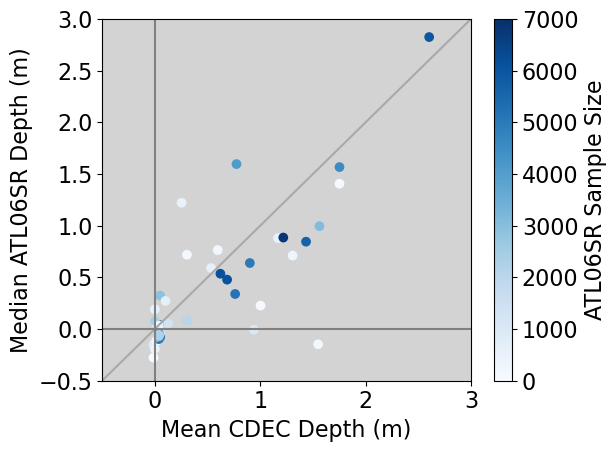

In [165]:
x = np.linspace(-0.7,3,100)
y = x

fig, ax = plt.subplots()
c=plt.scatter(comp_df['cdec_mean'], comp_df['median'], c=comp_df['n'], cmap='Blues', vmin=0, vmax=7000)
plt.plot(x, y, 'darkgrey', label='1:1 line')
plt.axvline(x=0, ymin=(-0.7), ymax=3, color='grey')
plt.axhline(y=0, xmin=(-0.7), xmax=3, color='grey')
plt.colorbar(c, label='ATL06SR Sample Size')
plt.ylim(-0.5, 3)
plt.xlim(-0.5, 3)
plt.xlabel('Mean CDEC Depth (m)')
plt.ylabel('Median ATL06SR Depth (m)')
ax.set_facecolor('lightgrey')
plt.tight_layout()
#plt.savefig('../../figures/polished/median_dif_vs_delta_dan.jpeg', dpi=50

In [450]:
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


In [256]:
comp_tumradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[2, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38727/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [257]:
comp_danradius = make_comparison_table(atl06sr_gdf.loc[atl06sr_gdf.within(cdec_geom.loc[3, 'geometry'])])

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_38727/2378598872.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  comp_table_all.loc[comp_table_all.index==date,'snow_presence'] = np.nanmean(df.loc[df['acqdate']==pd.Timestamp(date), 'snow_presence'])


In [258]:
comp_tumradius = comp_tumradius.drop(columns=['dan_depth', 'atl06-dan_diff', 'atl06-dan_percent'])

In [259]:
comp_danradius = comp_danradius.drop(columns=['tum_depth', 'atl06-tum_diff', 'atl06-tum_percent'])

In [171]:
comp_tumradius.to_csv('../../figures/comp_tumradius.csv')
comp_danradius.to_csv('../../figures/comp_danradius.csv')

In [287]:
for data in [(comp_df[comp_df['snow_presence']==1]['iqr']), comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], \
             comp_df[comp_df['snow_presence']==1]['atl06-tum_percent'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], \
            comp_df[comp_df['snow_presence']==1]['atl06-dan_percent'], comp_tumradius[comp_tumradius['snow_presence']==1]['iqr'], \
            comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_percent'], \
            comp_danradius[comp_danradius['snow_presence']==1]['iqr']]:
    print(f'{data.name}', 'median =', np.nanmedian(data.abs()))

iqr median = 1.2492877224473204
atl06-tum_diff median = 0.21461617015184203
atl06-tum_percent median = 28.5410215215685
atl06-dan_diff median = 0.45702322967205566
atl06-dan_percent median = 41.48752070510733
iqr median = 0.7031003418849195
atl06-tum_diff median = 0.1799892255039115
atl06-tum_percent median = 22.81320125627248
atl06-dan_diff median = 0.543928369211129
atl06-dan_percent median = 44.87084964894188
iqr median = 0.7449141811357549


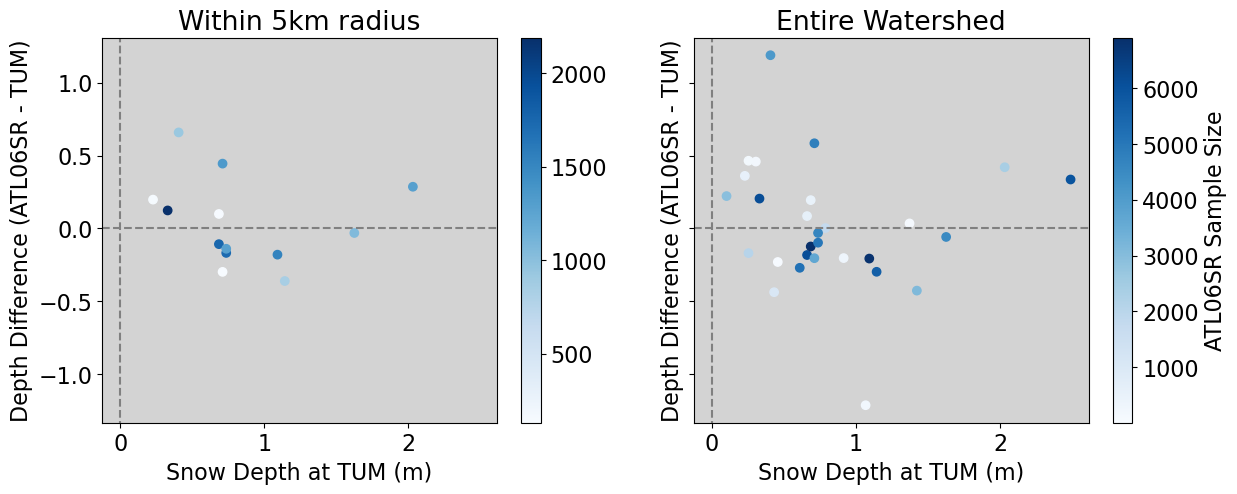

In [260]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_tumradius[comp_tumradius['snow_presence']==1]['tum_depth'], comp_tumradius[comp_tumradius['snow_presence']==1]['atl06-tum_diff'], c=comp_tumradius[comp_tumradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at TUM (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['tum_depth'], comp_df[comp_df['snow_presence']==1]['atl06-tum_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at TUM (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - TUM)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

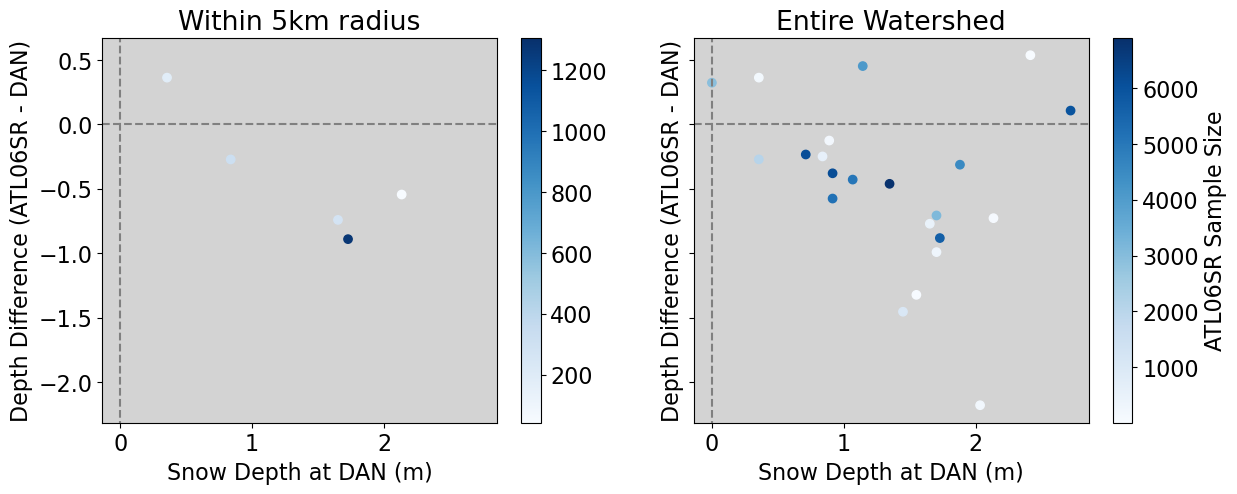

In [261]:
fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True, sharex=True)
#c = plt.scatter(comp_tumradius['tum_depth'], comp_tumradius['atl06-tum_diff'], c=comp_tumradius['n'], cmap='Blues')
c1 = ax[0].scatter(comp_danradius[comp_danradius['snow_presence']==1]['dan_depth'], comp_danradius[comp_danradius['snow_presence']==1]['atl06-dan_diff'], c=comp_danradius[comp_danradius['snow_presence']==1]['n'], cmap='Blues') # , linewidth=0, marker='.'
ax[0].set_xlabel('Snow Depth at DAN (m)')
ax[0].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[0].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[0].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[0].set_title('Within 5km radius')
ax[0].set_facecolor('lightgrey')
fig.colorbar(c1, ax=ax[0])

c = ax[1].scatter(comp_df[comp_df['snow_presence']==1]['dan_depth'], comp_df[comp_df['snow_presence']==1]['atl06-dan_diff'], c=comp_df[comp_df['snow_presence']==1]['n'], cmap='Blues')
ax[1].set_xlabel('Snow Depth at DAN (m)')
ax[1].set_ylabel('Depth Difference (ATL06SR - DAN)')
ax[1].axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
ax[1].axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')
ax[1].set_title('Entire Watershed')
ax[1].set_facecolor('lightgrey')
fig.colorbar(c, ax=ax[1], label='ATL06SR Sample Size')

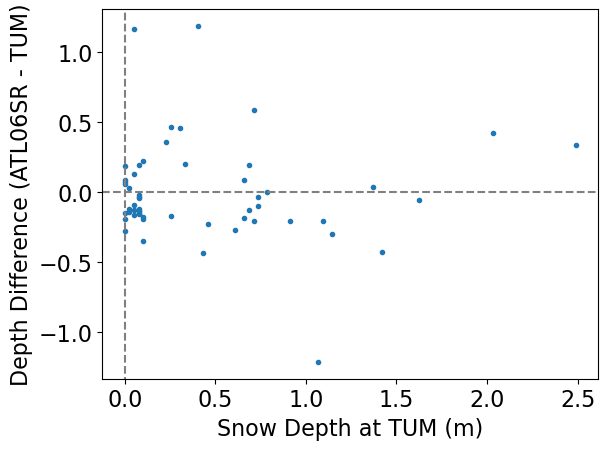

In [193]:
fig, ax = plt.subplots()
plt.plot(comp_df['tum_depth'], comp_df['atl06-tum_diff'], linewidth=0, marker='.')
plt.xlabel('Snow Depth at TUM (m)')
plt.ylabel('Depth Difference (ATL06SR - TUM)')
plt.axhline(y=0, xmin=0, xmax=2, c='grey', linestyle='--')
plt.axvline(x=0, ymin=-0.4, ymax=1, c='grey', linestyle='--')

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/numpy/lib/histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


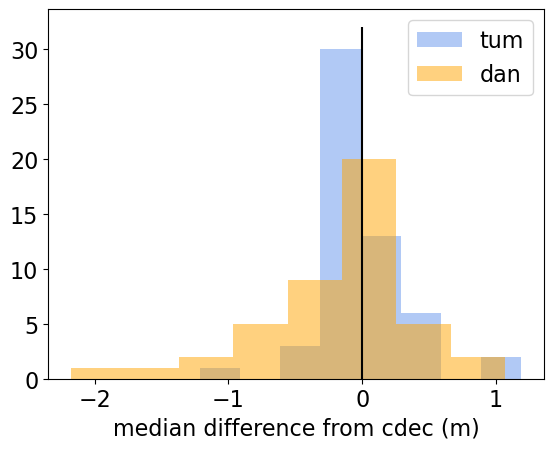

In [326]:
fig, ax = plt.subplots()
plt.hist(comp_table_all['atl06-tum_diff'], bins=round(np.sqrt(len(comp_table_all))), label='tum', alpha=0.5, color='cornflowerblue')
plt.hist(comp_table_all['atl06-dan_diff'], bins=round(np.sqrt(len(comp_table_all))), label='dan', alpha=0.5, color='orange')
plt.vlines(x=0, ymin=0, ymax=32, color='k')
plt.xlabel('median difference from cdec (m)')
#plt.ylabel('difference between \nATL06SR and CDEC')
plt.legend()

In [181]:
print('Median of the median differences between ATL06SR and DAN:', np.nanmedian(comp_table_all['atl06-dan_diff']))
print('Median of the median differences between ATL06SR and TUM:', np.nanmedian(comp_table_all['atl06-tum_diff']))

Median of the median differences between ATL06SR and DAN: -0.11778255058343248
Median of the median differences between ATL06SR and TUM: -0.09398747191903567
